In [2]:
from pathlib import Path
import numpy as np
import pprint

from myTools.read_spikeglx import get_exp_dir, get_geometry, read_spikeglx_meta

from probeinterface import Probe
from probeinterface.plotting import plot_probe

import spikeinterface as si
# import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
# import spikeinterface.postprocessing as spost
# import spikeinterface.qualitymetrics as sqm
# import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
# import spikeinterface.curation as scur
# import spikeinterface.widgets as sw


In [3]:
### Select experiment ###

from pathlib import Path
from myTools.read_spikeglx import get_exp_dir, get_geometry, read_spikeglx_meta
root_dir = Path(r"C:\Users\tanaka-users\tlab\tlab_yasui\NeuData")
exp_name = "pe7w1_ep001_001"

exp_dir = get_exp_dir(root_dir, exp_name)
exp_dir

WindowsPath('C:/Users/tanaka-users/tlab/tlab_yasui/NeuData/pe7w1_ep001_001_g0')

In [4]:
### Fetch meta and bin files ###

meta_name_ap = exp_dir.name + "_t0.imec0.ap.meta"
bin_name_ap = exp_dir.name + "_t0.imec0.ap.bin"
meta_name_lf = exp_dir.name + "_t0.imec0.lf.meta"
bin_name_lf = exp_dir.name + "_t0.imec0.lf.bin"
meta_name_obx = exp_dir.name + "_t0.obx0.obx.meta"
bin_name_obx = exp_dir.name + "_t0.obx0.obx.bin"

sub_dir_name = exp_dir.name + "_imec0"

bin_fpath_ap = exp_dir / sub_dir_name / bin_name_ap
meta_fpath_ap = exp_dir / sub_dir_name / meta_name_ap
bin_fpath_lf = exp_dir / sub_dir_name / bin_name_lf
meta_fpath_lf = exp_dir / sub_dir_name / meta_name_lf
bin_fpath_obx = exp_dir / bin_name_obx
meta_fpath_obx = exp_dir / meta_name_obx

meta_ap = read_spikeglx_meta(meta_fpath_ap)
meta_lf = read_spikeglx_meta(meta_fpath_lf)
meta_obx = read_spikeglx_meta(meta_fpath_obx)


In [5]:
### Get recording info ###

sampling_frequency = float(meta_ap['imSampRate'])
num_channels = int(meta_ap['nSavedChans'])
num_frames = int(meta_ap.get('fileSizeBytes', 0)) // (num_channels * 2)  # 2 bytes per sample (int16)
print(f"{sampling_frequency}Hz - {num_channels}chan - {num_frames / sampling_frequency:.2f} sec")

30000.0Hz - 385chan - 319.70 sec


In [6]:
### Get AP recording ###

import spikeinterface as si  # import core only
ap_rec = si.read_binary(
    file_paths=bin_fpath_ap,
    sampling_frequency=sampling_frequency,
    num_channels=num_channels,
    dtype='int16',
    time_axis=0,  # time x channels
    is_filtered=False,
)
ap_channel_ids = ap_rec.get_channel_ids()[:num_channels-1]
recording = ap_rec.select_channels(ap_channel_ids)
recording

ChannelSliceRecording: 384 channels - 30.0kHz - 1 segments - 9,591,045 samples 
                       319.70s (5.33 minutes) - int16 dtype - 6.86 GiB

In [7]:
### Get probe geometry ###

import numpy as np
geometry = get_geometry(meta_ap)
unique_x = np.sort(np.unique(geometry[:,0]))
print(f"Unique x positions: {unique_x}")
unique_y = np.sort(np.unique(geometry[:,1]))
print(f"Unique y positions: {unique_y}")

Unique x positions: [15.5 21.5 27.5 33.5 39.5 45.5 51.5 57.5]
Unique y positions: [  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 114. 120. 126. 132. 138. 144. 150. 156. 162.
 168. 174. 180. 186. 192. 198. 204. 210. 216. 222. 228. 234. 240. 246.
 252. 258. 264. 270. 276. 282.]


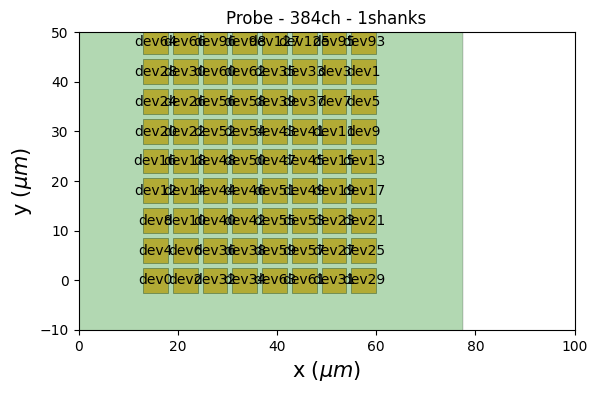

In [8]:
### Set probe to recording ###

from probeinterface import Probe
from probeinterface.plotting import plot_probe
probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=geometry, shapes='square', shape_params={'width': 5})
probe.set_device_channel_indices(np.arange(num_channels-1))
probe.create_auto_shape()

plot_probe(probe, with_contact_id=True, with_device_index=True, xlims=(0, 100), ylims=(-10, 50))
# recordingにプローブ情報を設定
recording = recording.set_probe(probe, in_place=False)

In [9]:
### Set gain and offset to recording ###

im_ai_range_max = float(meta_ap.get('imAiRangeMax', 0.6))
im_ai_range_min = float(meta_ap.get('imAiRangeMin', -0.6))
im_max_int = int(meta_ap.get('imMaxInt', 512))
ap_gain = float(meta_ap.get('imChan0apGain', 500))

# μVへの変換係数
gain_to_uv = (im_ai_range_max - im_ai_range_min) / (2 * im_max_int * ap_gain) * 1e6

# 現在のrecordingのチャンネル数を取得（SYNCチャンネルを除外した場合は384）
current_num_channels = recording.get_num_channels()

# すべてのチャンネルに同じゲインを設定
gains = np.full(current_num_channels, gain_to_uv, dtype='float32')
recording.set_channel_gains(gains)

# オフセットは0に設定
offsets = np.zeros(current_num_channels, dtype='float32')
recording.set_channel_offsets(offsets)
recording

ChannelSliceRecording: 384 channels - 30.0kHz - 1 segments - 9,591,045 samples 
                       319.70s (5.33 minutes) - int16 dtype - 6.86 GiB

In [10]:
### Check GPU memory ###

import torch
import gc

print("実行前のGPUメモリ状態:")
if torch.cuda.is_available():
    print(f"  割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  予約済み: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    
    # GPUキャッシュをクリア
    torch.cuda.empty_cache()
    gc.collect()
    
    print("\nクリア後のGPUメモリ状態:")
    print(f"  割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  予約済み: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("  CUDAが利用できません")

実行前のGPUメモリ状態:
  割り当て済み: 0.00 GB
  予約済み: 0.00 GB

クリア後のGPUメモリ状態:
  割り当て済み: 0.00 GB
  予約済み: 0.00 GB


In [11]:
### Setting sorters ###

do_preprocess = False
do_runsort = False

# sorters = ["dartsort", "kilosort4", "spykingcircus2"]
sorters = ["kilosort4"]
# sorters = ["spykingcircus2"]
# sorters = ["dartsort"]

sort_params_ds = ss.DARTsortSorter.default_params()
sort_params_ks4 = ss.Kilosort4Sorter.default_params()
sort_params_sc2 = ss.Spykingcircus2Sorter.default_params()

# DARTsort用パラメータ（メモリ削減版）

# Kilosort4用パラメータ
sort_params_ks4["torch_device"] = "cuda"
sort_params_ks4["save_extra_vars"] = True
# Spykingcircus2用パラメータ（必要に応じて調整）

# パラメータ辞書を作成
sort_params_dict = {
    "dartsort": sort_params_ds,
    "kilosort4": sort_params_ks4,
    "spykingcircus2": sort_params_sc2
}

# 選択されたソーターのパラメータを表示
print("\n" + "="*20 + " parameter " + "="*20)
for sorter in sorters:
    print(f"\n{'='*5} {sorter} {'='*5}")
    pprint.pprint(sort_params_dict[sorter])


==================== parameter ====================

===== kilosort4 =====
{'Th_learned': 8,
 'Th_single_ch': 6,
 'Th_universal': 9,
 'acg_threshold': 0.2,
 'artifact_threshold': inf,
 'bad_channels': None,
 'batch_size': 60000,
 'binning_depth': 5,
 'ccg_threshold': 0.25,
 'chunk_duration': '1s',
 'clear_cache': False,
 'cluster_downsampling': 1,
 'cluster_neighbors': 10,
 'delete_recording_dat': True,
 'dmin': None,
 'dminx': 32,
 'do_CAR': True,
 'do_correction': True,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'duplicate_spike_ms': 0.25,
 'fs': 30000,
 'highpass_cutoff': 300,
 'invert_sign': False,
 'keep_good_only': False,
 'max_channel_distance': 32,
 'max_cluster_subset': 25000,
 'max_peels': 100,
 'max_threads_per_worker': 1,
 'min_template_size': 10,
 'mp_context': None,
 'n_jobs': 1,
 'n_pcs': 6,
 'n_templates': 6,
 'nblocks': 1,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'nskip': 25,
 'nt': 61,
 'nt0min': None,
 'pool_engine': 'process',
 'position_limit': 100,
 'progress

In [12]:
### Preprocess recording ###

if do_preprocess:
    for sorter in sorters:

        print("="*5, sorter, "="*5)
        folder = exp_dir / sorter

        if sorter == "kilosort4":
            recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            recording_cmr = spre.common_reference(recording_f, reference="global")
            recording_whiten = spre.whiten(recording_cmr, int_scale=200)
            recording_motion = spre.correct_motion(recording_whiten, preset="kilosort_like")
            recording_preprocessed = recording_motion.save(
                format="binary", 
                folder=folder / "pp_rec", 
                overwrite=True
                )
        else:
            recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
            recording_preprocessed = recording_cmr.save(
                format="binary", 
                folder=folder / "pp_rec", 
                overwrite=True
                )
else:
    print("skip preprocessing.")

skip preprocessing.


In [13]:
### Run sort ###

import torch
import gc

if do_runsort:
    sorting_list = []
    analyzer_list = []
    for sorter in sorters:
        print("="*5, sorter, "="*5)
        recording_preprocessed = si.load(exp_dir / sorter / "pp_rec")
        try:
            sorting = ss.run_sorter(
                sorter_name=sorter,
                folder=exp_dir / sorter / "sorting" , 
                remove_existing_folder=True, 
                recording=recording_preprocessed, 
                **sort_params_dict[sorter]
                )

            analyzer = si.create_sorting_analyzer(
                sorting=sorting, 
                recording=recording_preprocessed, 
                format='binary_folder', 
                folder=exp_dir / sorter / "analyzer", 
                overwrite=True
                )
            
            print("===== Sorting done =====")

        except Exception as e:
            print(f"Error occurred: {e}")
            
            # エラー時もメモリをクリア
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                gc.collect()
            continue
        finally:
            # 使用済み変数を削除
            if 'recording_preprocessed' in locals():
                del recording_preprocessed
            
            # 各ソーター実行後にGPUメモリをクリア
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                gc.collect()
                print(f"  GPUメモリクリア完了 - 割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

In [14]:
from myTools.exchange import exchange_kilosort4_results
from kilosort.io import load_ops
import pandas as pd
import numpy as np


def safe_load_npy(file_path, allow_pickle=True):
    try:
        return np.load(file_path, allow_pickle=allow_pickle)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.array([])

def safe_load_csv(file_path, sep="\t"):
    try:
        return pd.read_csv(file_path, sep=sep).to_numpy()
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return []

res_dir = exp_dir / "kilosort4" / "sorting" / "sorter_output"
res_dir = Path(res_dir)

amplitudes = safe_load_npy(res_dir / "amplitudes.npy")
channel_map = safe_load_npy(res_dir / "channel_map.npy")
channel_positions = safe_load_npy(res_dir / "channel_positions.npy")
channel_shanks = safe_load_npy(res_dir / "channel_shanks.npy")
cluster_Amplitude = safe_load_csv(res_dir / "cluster_Amplitude.tsv", sep="\t")
cluster_ContamPct = safe_load_csv(res_dir / "cluster_ContamPct.tsv", sep="\t")
cluster_group = safe_load_csv(res_dir / "cluster_group.tsv", sep="\t")
cluster_KSLabel = safe_load_csv(res_dir / "cluster_KSLabel.tsv", sep="\t")
kept_spikes = safe_load_npy(res_dir / "kept_spikes.npy")
ops = load_ops(res_dir / "ops.npy")
pc_features_ind = safe_load_npy(res_dir / "pc_features_ind.npy")
pc_features = safe_load_npy(res_dir / "pc_features.npy")
similar_templates = safe_load_npy(res_dir / "similar_templates.npy")
spike_clusters = safe_load_npy(res_dir / "spike_clusters.npy")
spike_detection_templates = safe_load_npy(res_dir / "spike_detection_templates.npy")
spike_positions = safe_load_npy(res_dir / "spike_positions.npy")
spike_templates = safe_load_npy(res_dir / "spike_templates.npy")
spike_times = safe_load_npy(res_dir / "spike_times.npy")
templates = safe_load_npy(res_dir / "templates.npy")
templates_ind = safe_load_npy(res_dir / "templates_ind.npy")
whitening_mat = safe_load_npy(res_dir / "whitening_mat.npy")
whitening_mat_data = safe_load_npy(res_dir / "whitening_mat_dat.npy")
whitening_mat_inv = safe_load_npy(res_dir / "whitening_mat_inv.npy")


Error loading C:\Users\tanaka-users\tlab\tlab_yasui\NeuData\pe7w1_ep001_001_g0\kilosort4\sorting\sorter_output\pc_features_ind.npy: [Errno 2] No such file or directory: 'C:\\Users\\tanaka-users\\tlab\\tlab_yasui\\NeuData\\pe7w1_ep001_001_g0\\kilosort4\\sorting\\sorter_output\\pc_features_ind.npy'


In [15]:
from scipy.io import savemat
import numpy as np
import torch

def replace_none_recursive(data):
    # 辞書の場合の処理
    if isinstance(data, dict):
        return {
            str(k) if isinstance(k, int) else k: replace_none_recursive(v) 
            for k, v in data.items()
        }
    
    # リストやタプルの場合の処理
    elif isinstance(data, (list, tuple)):
        # リスト内包表記で各要素を再帰的に処理
        return type(data)(replace_none_recursive(item) for item in data)
    
    # PyTorchテンソルの場合の処理（CPUに移動してnumpy配列に変換）
    elif isinstance(data, torch.Tensor):
        return data.cpu().numpy()
    
    # numpy配列の場合の処理
    elif isinstance(data, np.ndarray):
        return data
    
    # numpy dtype の場合の処理（文字列に変換）
    elif isinstance(data, np.dtype):
        return str(data)
    
    # 値が None の場合の処理
    elif data is None:
        return 'None'
    
    # その他の値（文字列、数値など）はそのまま返す
    else:
        return data

replaced_ops = replace_none_recursive(ops)
savemat(res_dir / 'ops.mat', {'ops': replaced_ops}, long_field_names=True)

In [16]:
results_dict = {
    'amplitudes': amplitudes,
    'spike_times': spike_times,
    'spike_positions': spike_positions,
    'pc_features': pc_features,
    'templates': templates,
    'similar_templates': similar_templates,
    'cluster_KSLabel': cluster_KSLabel,
    'cluster_ContamPct': cluster_ContamPct,
    'cluster_Amplitude': cluster_Amplitude,
    'spike_clusters': spike_clusters,
    'kept_spikes': kept_spikes,
    'pc_features_ind': pc_features_ind,
    'similar_templates': similar_templates,
    'spike_templates': spike_templates,
    'spike_positions': spike_positions,
    'spike_templates': spike_templates,
    'whitening_mat': whitening_mat,
    'whitening_mat_data': whitening_mat_data,
    'whitening_mat_inv': whitening_mat_inv,
}

savemat(res_dir / 'results.mat', results_dict, long_field_names=True, format='5')



In [17]:
from probeinterface.io import write_probeinterface

write_probeinterface(res_dir / 'probe.json', probe_or_probegroup=probe)

In [20]:
import numpy as np
# from scipy.io import savemat
import h5py

# 記録データ（NumPy配列）を取得
recording = si.load(exp_dir / "kilosort4" / "pp_rec")
print(recording.get_num_channels())
traces = recording.get_traces(return_in_uV=False) # スケール適用後のデータを取得推奨
print(traces.shape)
# .matファイルとして保存
# savemat(res_dir / 'recording.mat', {'traces': traces})

with h5py.File(res_dir / 'recording.h5', 'w') as f:
    f.create_dataset('traces', data=traces)
    # f.create_dataset('channel_ids', data=recording.get_channel_ids())
    # f.create_dataset('channel_locations', data=recording.get_channel_locations())
    # f.create_dataset('sampling_frequency', data=recording.get_sampling_frequency())



384
(9591045, 384)


In [ ]:
from kilosort.run_kilosort import load_sorting
ks_dir = exp_dir / "kilosort4" / "sorting" / "sorter_output"
ops, st, clu, similar_templates, \
    is_ref, est_contam_rate, kept_spikes = \
            load_sorting(ks_dir, device="cuda")

from kilosort.plots import plot_drift_amount, plot_drift_scatter, plot_diagnostics, plot_spike_positions
plot_drift_amount(ops, ks_dir)
# plot_drift_scatter(st, ks_dir)
# plot_diagnostics(Wall, clu, ops, ks_dir)
plot_spike_positions(clu, is_ref, ks_dir)



In [ ]:
extensions_to_compute = [
    "random_spikes",
    "waveforms",
    "noise_levels",
    "templates",
    "spike_amplitudes",
    "unit_locations",
    "spike_locations",
    "correlograms",
    "template_similarity"
]

extension_params = {
    "unit_locations": {"method": "center_of_mass"},
    "spike_locations": {"ms_before": 0.1},
    "correlograms": {"bin_ms": 0.1},
    "template_similarity": {"method": "cosine_similarity"}
}
try:
    if len(analyzer_list) == 0:
        for sorter in sorters:
            try:
                analyzer = si.load_sorting_analyzer(folder= exp_dir / sorter / "analyzer")
                print("="*5, sorter, "="*5)
                possible_extensions = analyzer.get_computable_extensions()
                print(possible_extensions)
                print(analyzer.has_recording())
                sexp.export_to_phy(sorting_analyzer=analyzer, output_folder= exp_dir / sorter / "phy", remove_if_exists=True)
            except Exception as e:
                print(f"Error loading analyzer: {e}")
                continue
    else:
        for index, analyzer in enumerate(analyzer_list):
            try:
                print("="*5, sorters[index], "="*5)
                possible_extensions = analyzer.get_computable_extensions()
                print(possible_extensions)
                print(analyzer.has_recording())
                analyzer.compute(extensions_to_compute, extension_params=extension_params)
            except Exception as e:
                print(f"Error loading analyzer: {e}")
                continue
except NameError:
    print("No analyzer list found.")
    analyzer_list = []
    for sorter in sorters:
        try:
            analyzer = si.load_sorting_analyzer(folder= exp_dir / sorter / "analyzer")
            print("="*5, sorter, "="*5)
            possible_extensions = analyzer.get_computable_extensions()
            print(possible_extensions)
            print(analyzer.has_recording())
        except Exception as e:
            print(f"Error loading analyzer: {e}")
            continue

===== kilosort4 =====
['random_spikes', 'waveforms', 'templates', 'noise_levels', 'amplitude_scalings', 'correlograms', 'isi_histograms', 'principal_components', 'spike_amplitudes', 'spike_locations', 'template_metrics', 'template_similarity', 'unit_locations', 'quality_metrics']
True


write_binary_recording (no parallelization):  10%|█         | 33/320 [00:32<04:44,  1.01it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt